In [9]:
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models.forecasting.rnn_model import RNNModel
from darts.models.forecasting.tcn_model import TCNModel
from darts.models.forecasting.transformer_model import TransformerModel
from darts.models.forecasting.nbeats import NBEATSModel
from darts.models.forecasting.block_rnn_model import BlockRNNModel

from darts.metrics import mape, smape
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20,15)
import pandas as pd

<Axes: xlabel='Date'>

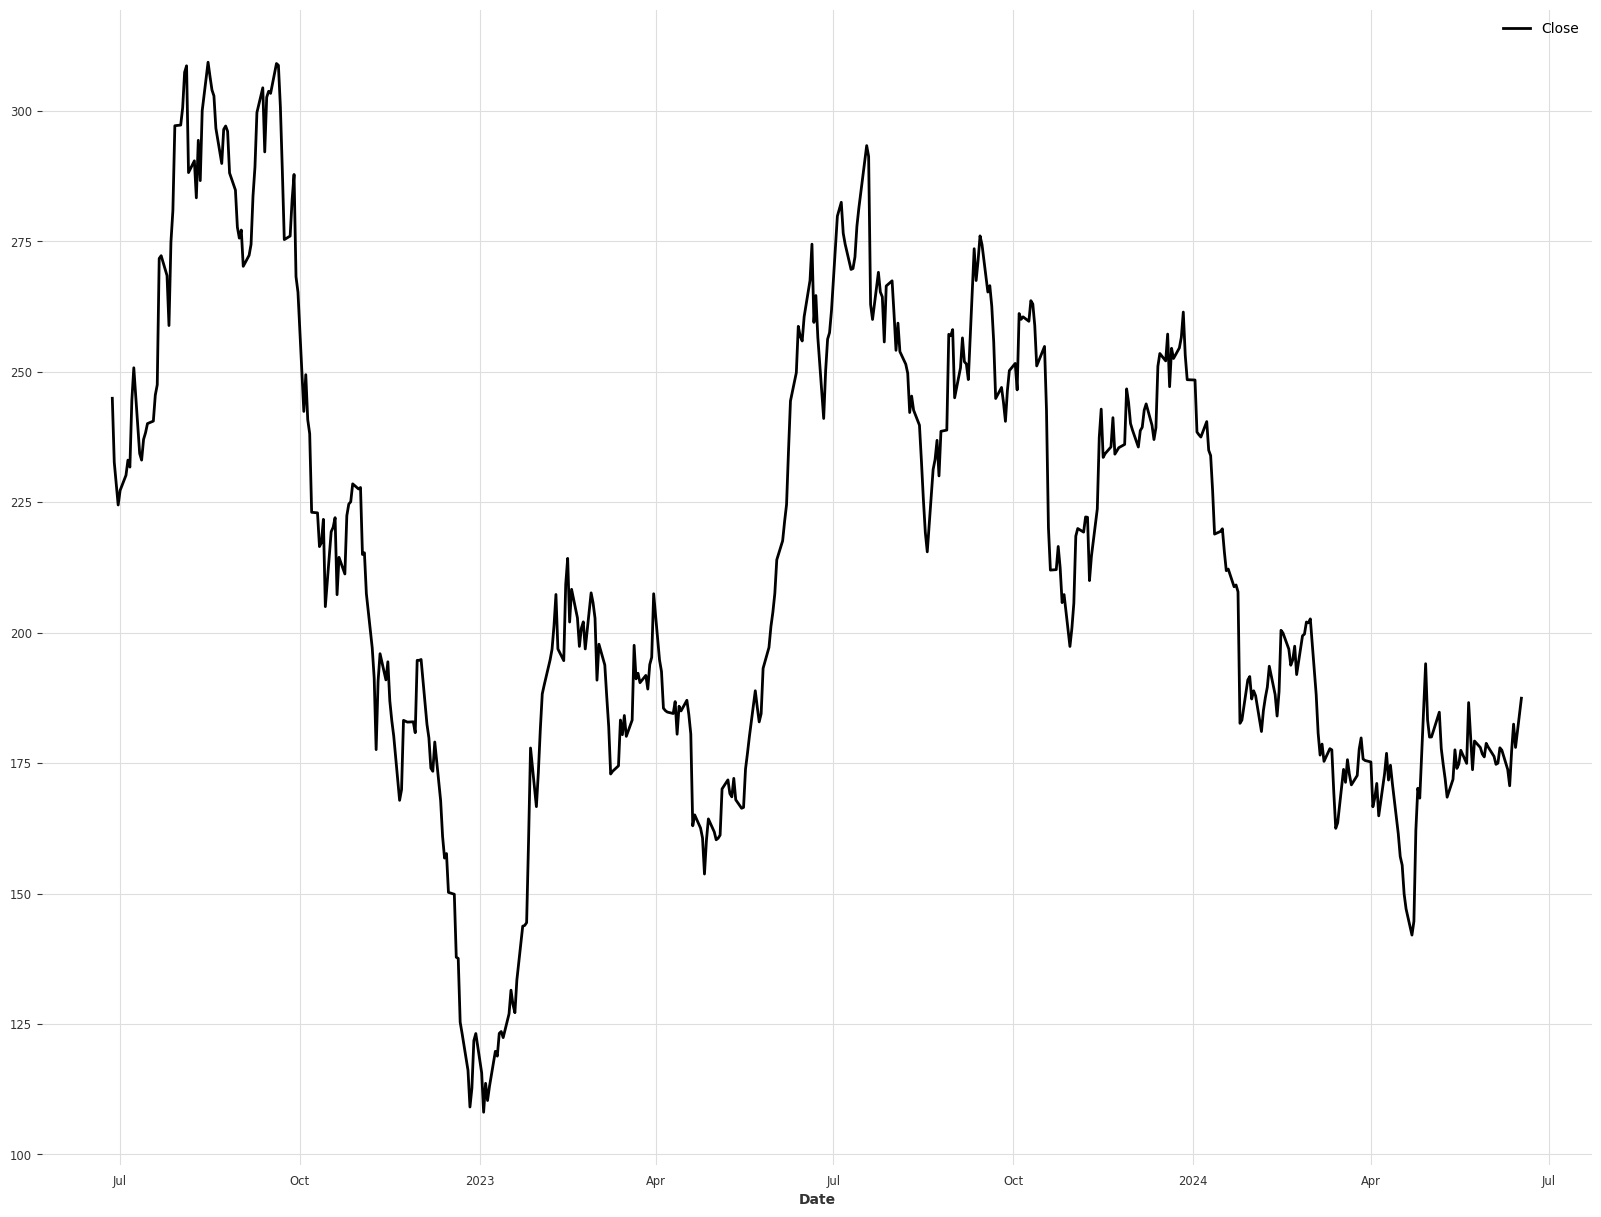

In [192]:
stock_price=pd.read_csv('../data/TSLA.csv')
stock_price['Date']=pd.to_datetime(stock_price['Unnamed: 0'])
#transform column Close to float32 type
stock_price['Close']=stock_price['Close'].astype('Float32')
stock_price_ts=TimeSeries.from_dataframe(stock_price, time_col='Date', value_cols=['Close'],
                                          fill_missing_dates=True, freq='B')  # 'B' stands for business day frequency
from darts.utils.missing_values import fill_missing_values
stock_price_ts = fill_missing_values(stock_price_ts)
stock_price_ts.plot()

In [193]:
split_date='2024-04-01'
train_stock, val_stock = stock_price_ts.split_before(pd.Timestamp(split_date))
scaler_stock = Scaler()
scaler_stock=scaler_stock.fit(train_stock)
train_stock_scaled = scaler_stock.transform(train_stock)
val_stock_scaled = scaler_stock.transform(val_stock)
stock_scaled = scaler_stock.transform(stock_price_ts)


### 

# Start from Exponential Smohing, ARIMA and Linear models

In [102]:
from darts.models.forecasting.linear_regression_model import LinearRegressionModel, LinearRegression
from darts.models.forecasting.arima import ARIMA
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing

## Linear Regression

MAPE:
Linear regression:  15.33 %


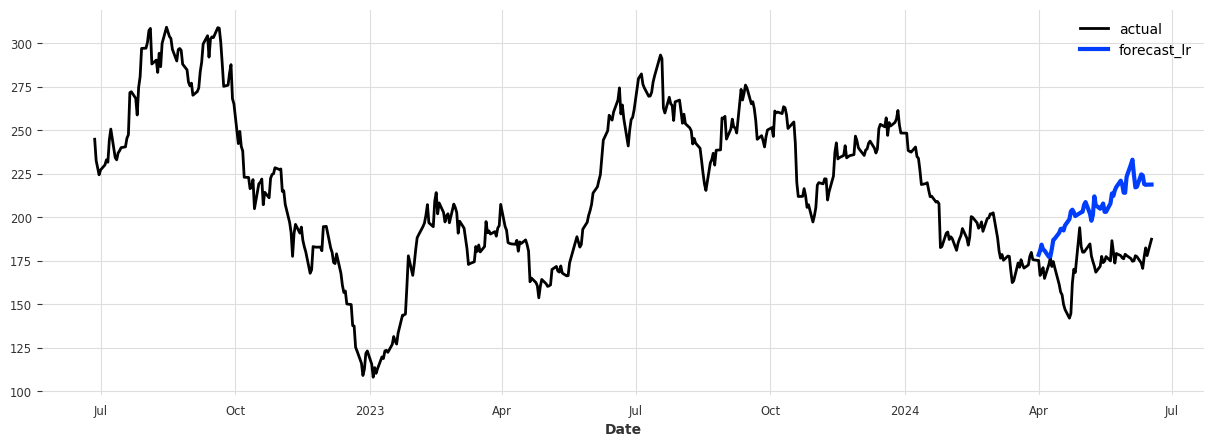

In [104]:


model_lr = LinearRegressionModel(
    lags=len(val_stock)*2,
    output_chunk_length=len(val_stock),
    )

model_lr.fit(train_stock)
prediction_lr = model_lr.predict(len(val_stock))

print('MAPE:')
print('Linear regression: ', np.round(mape(prediction_lr, val_stock),2), '%')

plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
prediction_lr.plot(label='forecast_lr', lw=3)
plt.legend()

Add hyperparameter tunning for Linear Regression model for testing period 

Best parameters: {'lags': 56, 'output_chunk_length': 28}
MAPE on validation set: 10.54%


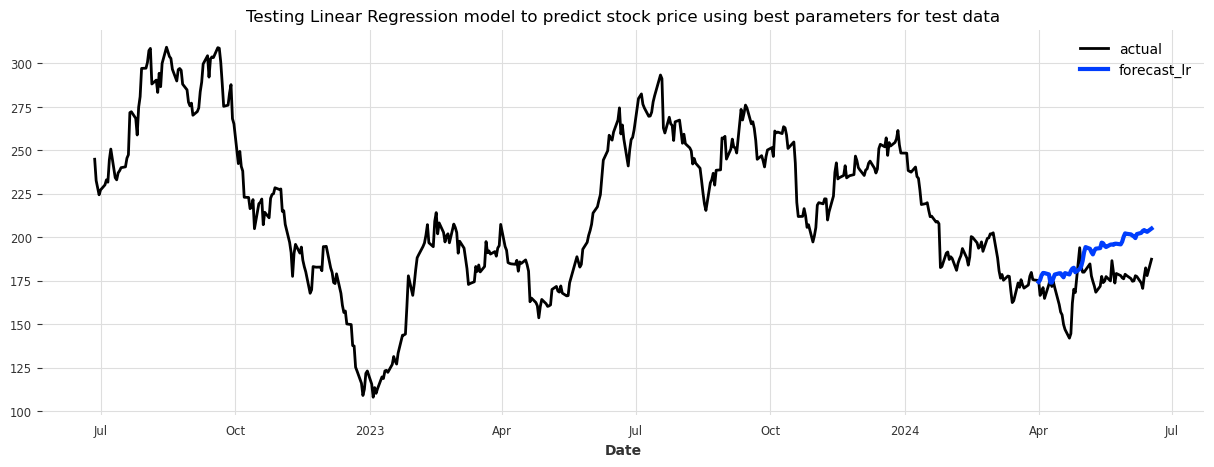

In [173]:
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mse
from sklearn.model_selection import ParameterGrid
from typing import Dict

def evaluate_model(model, train, val):
    model.fit(train)
    prediction = model.predict(len(val))
    return mse(val, prediction)

def hyperparameter_tuning(train_stock: TimeSeries, val_stock: TimeSeries) -> Dict:
    # Define the hyperparameter search space
    param_grid = {
        'lags': [#3,5,7,
                 int(len(val_stock)/4),int(len(val_stock)/2),len(val_stock), len(val_stock)*2, len(val_stock)*3],
        'output_chunk_length': [1, len(val_stock)//2, len(val_stock)]
    }

    best_mse = float('inf')
    best_params = None

    # Perform grid search
    for params in ParameterGrid(param_grid):
        model = LinearRegressionModel(**params)
        current_mse = evaluate_model(model, train_stock, val_stock)

        if current_mse < best_mse:
            best_mse = current_mse
            best_params = params

    return best_params

# Assuming train_stock and val_stock are your TimeSeries objects
best_params = hyperparameter_tuning(train_stock, val_stock)

# Train the final model with the best parameters
final_model = LinearRegressionModel(**best_params)
final_model.fit(train_stock)
prediction_lr = final_model.predict(len(val_stock))

print(f"Best parameters: {best_params}")
print(f"MAPE on validation set: {np.round(mape(val_stock, prediction_lr),2,)}%")

plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
prediction_lr.plot(label='forecast_lr', lw=3)
plt.title('Testing Linear Regression model to predict stock price using best parameters for test data')
plt.legend()
plt.show()


Hyperparameter tunning for the different areas of time series, chunks of validation set length 30 

Best parameters: {'lags': 3, 'output_chunk_length': 7}


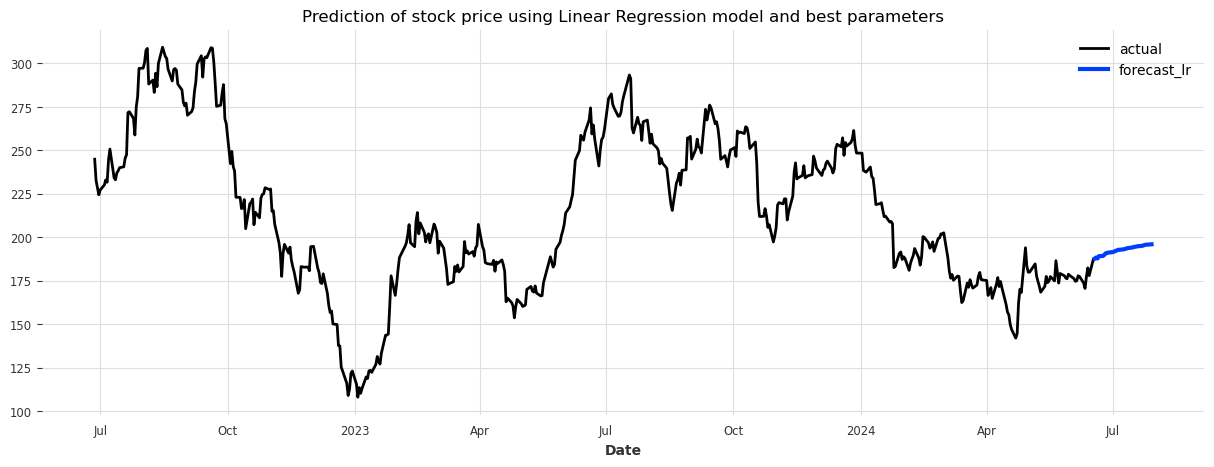

In [203]:
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mse
from sklearn.model_selection import ParameterGrid
from typing import Dict, List
import numpy as np

def create_train_val_splits(series: TimeSeries, n_splits: int, val_length: int) -> List[tuple]:
    splits = []
    step = (len(series) - val_length) // n_splits
    for i in range(n_splits):
        train_end = len(series) - val_length - (n_splits - i - 1) * step
        val_start = train_end
        val_end = val_start + val_length
        
        train = series[:train_end]
        val = series[val_start:val_end]
        splits.append((train, val))
    return splits

def evaluate_model(model, splits: List[tuple]) -> float:
    mse_scores = []
    for train, val in splits:
        if np.abs(np.min(model.lags['target'])-model.output_chunk_length)>len(train):
            continue
        model.fit(train)
        prediction = model.predict(len(val))
        mse_scores.append(mape(val, prediction))
    return np.mean(mse_scores)

def hyperparameter_tuning(series: TimeSeries, n_splits: int, val_length: int) -> Dict:
    # Define the hyperparameter search space
    param_grid = {
        'lags': [2,3,4,5,val_length, val_length*2, val_length*3],
        'output_chunk_length': [1, val_length//2, val_length]
    }

    splits = create_train_val_splits(series, n_splits, val_length)

    best_mse = float('inf')
    best_params = None

    # Perform grid search
    for params in ParameterGrid(param_grid):
        model = LinearRegressionModel(**params)
        current_mse = evaluate_model(model, splits)
        #print(np.round(current_mse,2))
        if current_mse < best_mse:
            best_mse = current_mse
            best_params = params

    return best_params

# Usage example
series = stock_price_ts
n_splits = 10  # Number of validation splits
val_length = 14  # Length of each validation period

best_params = hyperparameter_tuning(series, n_splits, val_length)

# Train the final model with the best parameters on the full dataset
final_model = LinearRegressionModel(**best_params)
final_model.fit(series)

print(f"Best parameters: {best_params}")

# To make a prediction
future_prediction = final_model.predict(30)  # Predict next 30 time steps

plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
future_prediction.plot(label='forecast_lr', lw=3)
plt.legend()
plt.title('Prediction of stock price using Linear Regression model and best parameters')
plt.show()

Apply defined most robust model for the validation set to calculate an error

MAPE:
Linear regression:  7.94 %


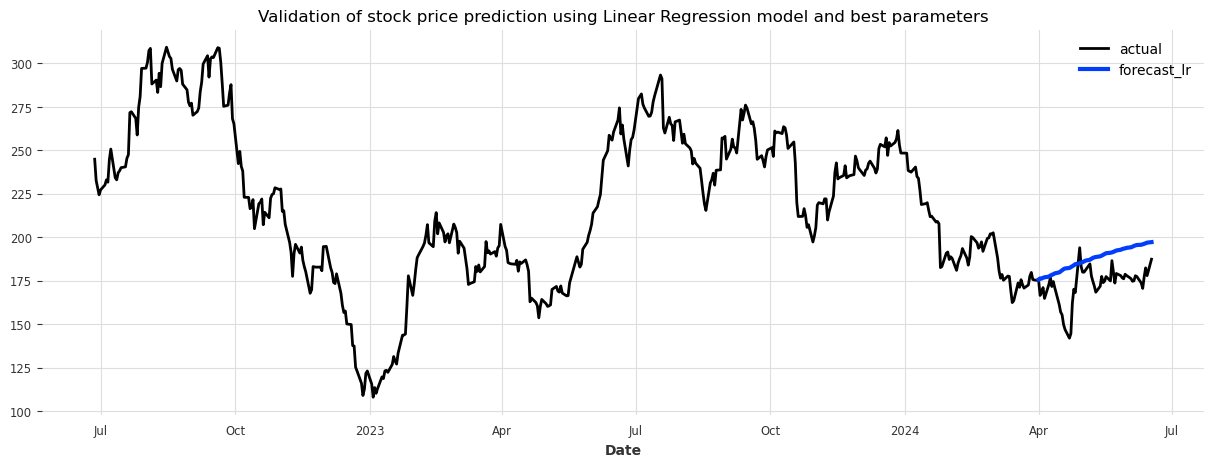

In [204]:
#Apply defined most robust model for the validation set to calculate an error
final_model.fit(train_stock)
prediction_lr = final_model.predict(len(val_stock))

lr_mape=np.round(mape(prediction_lr, val_stock),2)
print('MAPE:')
print(f'Linear regression: {lr_mape}%')

#plot the prediction
plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
prediction_lr.plot(label='forecast_lr', lw=3)
plt.legend()
plt.title('Validation of stock price prediction using Linear Regression model and best parameters')
plt.show()


## Exponential Smoothing

Error with parameters {'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': None, 'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>}: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters {'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 7, 'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>}: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters {'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 12, 'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>}: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters {'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': None, 'trend': <ModelMode.ADDITIVE: 'additive'>}: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters {'seaso

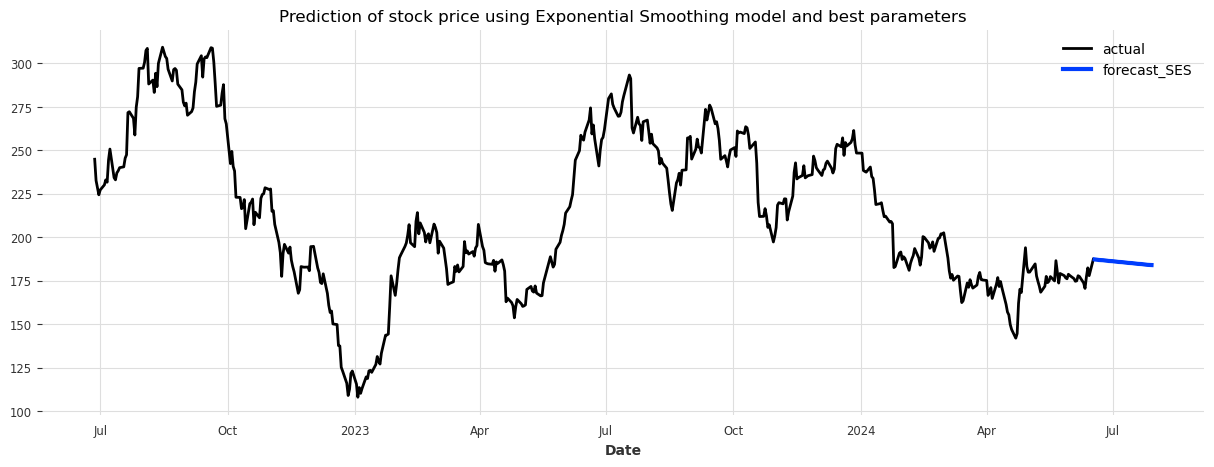

In [201]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mse
from sklearn.model_selection import ParameterGrid
from typing import Dict, List
import numpy as np

def create_train_val_splits(series: TimeSeries, n_splits: int, val_length: int) -> List[tuple]:
    splits = []
    step = (len(series) - val_length) // n_splits
    for i in range(n_splits):
        train_end = len(series) - val_length - (n_splits - i - 1) * step
        val_start = train_end
        val_end = val_start + val_length
        
        train = series[:train_end]
        val = series[val_start:val_end]
        splits.append((train, val))
    return splits

def evaluate_model(model, splits: List[tuple]) -> float:
    mse_scores = []
    for train, val in splits:
        model.fit(train)
        prediction = model.predict(len(val))
        mse_scores.append(mse(val, prediction))
    return np.mean(mse_scores)
from darts.utils.utils import ModelMode, SeasonalityMode
def hyperparameter_tuning(series: TimeSeries, n_splits: int, val_length: int) -> Dict:
    # Define the hyperparameter search space
    param_grid = {
        'seasonal_periods': [None, 7, 12],  # Adjust based on your data's seasonality
        'trend': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
        'seasonal': [SeasonalityMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.NONE],
        #'damped': [True, False],
        #'use_boxcox': [True, False],
    }

    splits = create_train_val_splits(series, n_splits, val_length)

    best_mse = float('inf')
    best_params = None

    # Perform grid search
    for params in ParameterGrid(param_grid):
        model = ExponentialSmoothing(**params)
        try:
            current_mse = evaluate_model(model, splits)

            if current_mse < best_mse:
                best_mse = current_mse
                best_params = params
        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
            continue

    return best_params

# Usage example
series = stock_price_ts  # Replace with your actual data
#Replace with scaled data
series=stock_scaled
n_splits = 5  # Number of validation splits
val_length = 14  # Length of each validation period

best_params = hyperparameter_tuning(series, n_splits, val_length)

# Train the final model with the best parameters on the full dataset
final_model = ExponentialSmoothing(**best_params)
final_model.fit(series)

print(f"Best parameters: {best_params}")

# To make a prediction
future_prediction = scaler_stock.inverse_transform(final_model.predict(30))  # Predict next 30 time steps

plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
future_prediction.plot(label='forecast_SES', lw=3)
plt.legend()
plt.title('Prediction of stock price using Exponential Smoothing model and best parameters')
plt.show()



MAPE:
Exponential Smoothing:  5.36 %


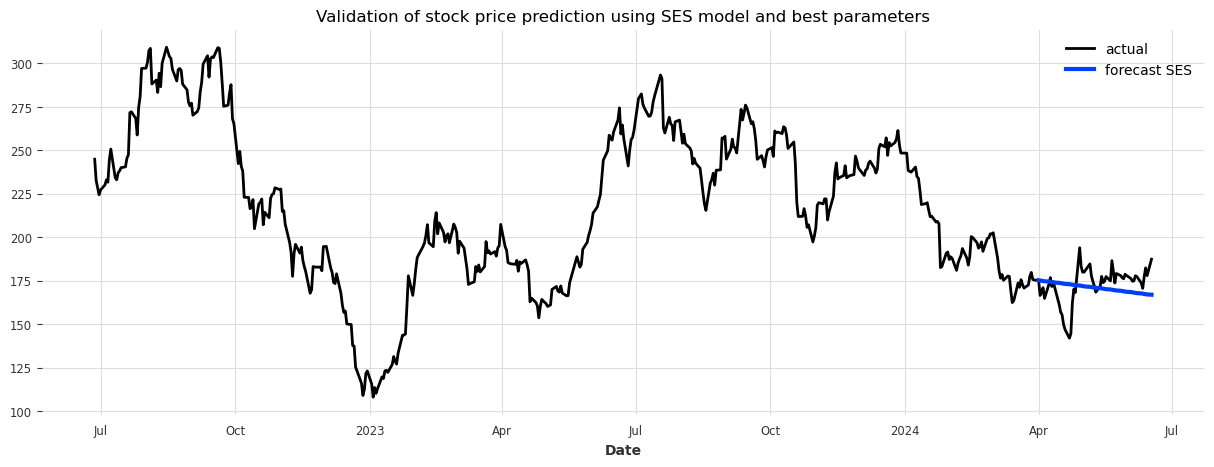

In [202]:
#Apply defined most robust model for the validation set to calculate an error
final_model.fit(train_stock_scaled)
prediction_ses = scaler_stock.inverse_transform(final_model.predict(len(val_stock)))
ses_mape=np.round(mape(prediction_ses, val_stock),2)
print('MAPE:')
print(f'Exponential Smoothing: {ses_mape}%')

print('MAPE:')
print('Exponential Smoothing: ', np.round(mape(prediction_ses, val_stock),2), '%')

#plot the prediction
plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
prediction_ses.plot(label='forecast SES', lw=3)
plt.legend()
plt.title('Validation of stock price prediction using SES model and best parameters')
plt.show()


## ARIMA model

Best parameters: {'p': 2, 'd': 0, 'q': 1}


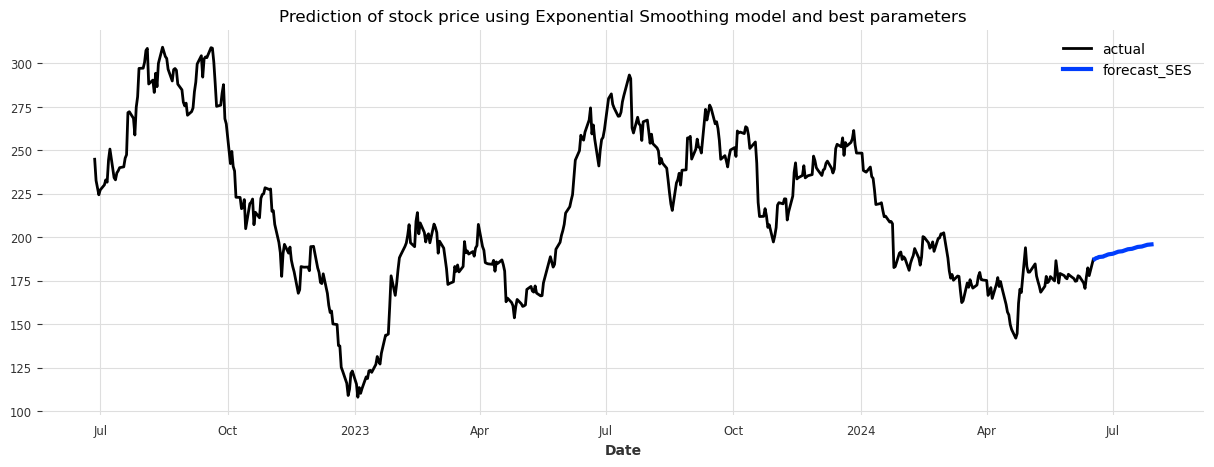

In [208]:
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mse
from itertools import product
from typing import Dict, List
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # To suppress convergence warnings

def create_train_val_splits(series: TimeSeries, n_splits: int, val_length: int) -> List[tuple]:
    splits = []
    step = (len(series) - val_length) // n_splits
    for i in range(n_splits):
        train_end = len(series) - val_length - (n_splits - i - 1) * step
        val_start = train_end
        val_end = val_start + val_length
        
        train = series[:train_end]
        val = series[val_start:val_end]
        splits.append((train, val))
    return splits

def evaluate_model(model, splits: List[tuple]) -> float:
    mse_scores = []
    for train, val in splits:
        try:
            model.fit(train)
            prediction = model.predict(len(val))
            mse_scores.append(mse(val, prediction))
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            return float('inf')  # Return a high MSE to discourage this parameter set
    return np.mean(mse_scores) if mse_scores else float('inf')

def hyperparameter_tuning(series: TimeSeries, n_splits: int, val_length: int) -> Dict:
    # Define the hyperparameter search space
    p_values = range(0, 3)  # AR parameter
    d_values = range(0, 2)  # Differencing
    q_values = range(0, 3)  # MA parameter
    
    param_grid = list(product(p_values, d_values, q_values))

    splits = create_train_val_splits(series, n_splits, val_length)

    best_mse = float('inf')
    best_params = None

    # Perform grid search
    for p, d, q in param_grid:
        model = ARIMA(p=p, d=d, q=q)
        try:
            current_mse = evaluate_model(model, splits)

            if current_mse < best_mse:
                best_mse = current_mse
                best_params = {'p': p, 'd': d, 'q': q}
        except Exception as e:
            print(f"Error with parameters (p={p}, d={d}, q={q}): {str(e)}")
            continue

    return best_params

# Usage example
series =  stock_scaled # Replace with your actual data
n_splits = 10  # Number of validation splits
val_length = 30  # Length of each validation period

# Scale the data
from darts.dataprocessing.transformers import Scaler


best_params = hyperparameter_tuning(series, n_splits, val_length)

# Train the final model with the best parameters on the full dataset
final_model = ARIMA(**best_params)
final_model.fit(series)

print(f"Best parameters: {best_params}")

# To make a prediction
future_prediction = final_model.predict(30)  # Predict next 30 time steps
arima_prediction = scaler_stock.inverse_transform(future_prediction)

plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
arima_prediction.plot(label='forecast_SES', lw=3)
plt.legend()
plt.title('Prediction of stock price using Exponential Smoothing model and best parameters')
plt.show()


MAPE:
ARIMA: 8.94%


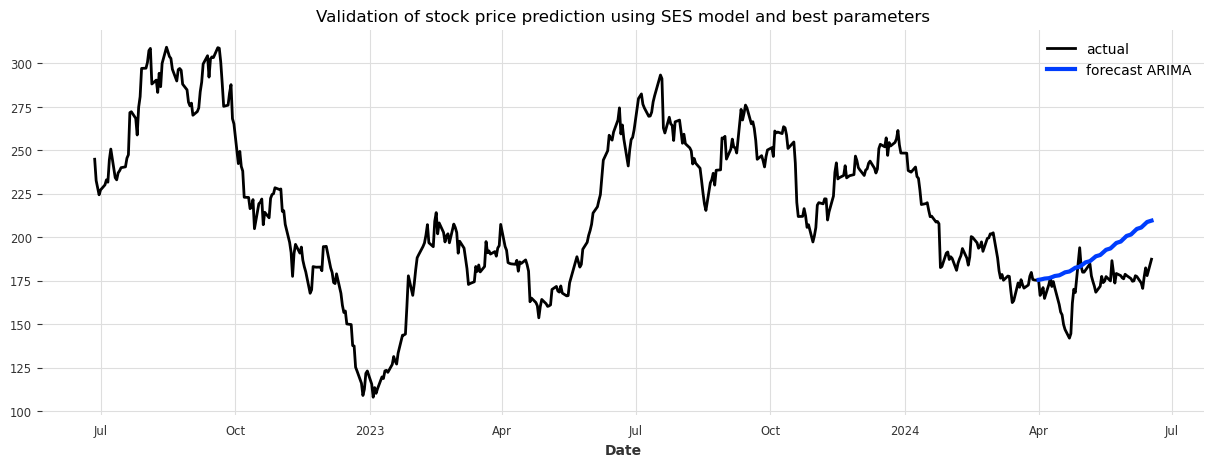

In [211]:
#Apply defined most robust model for the validation set to calculate an error
final_model.fit(train_stock_scaled)
prediction_arima = scaler_stock.inverse_transform(final_model.predict(len(val_stock)))
arima_mape=np.round(mape(prediction_arima, val_stock),2)
print('MAPE:')
print(f'ARIMA: {arima_mape}%')

#plot the prediction
plt.figure(figsize=(15,5))
stock_price_ts.plot(label='actual')
prediction_arima.plot(label='forecast ARIMA', lw=3)
plt.legend()
plt.title('Validation of stock price prediction using SES model and best parameters')
plt.show()
